# Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, Dataset

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Loading the Dataset

In [2]:
data_directory = "data/Car_data/car_data" 

X_data = []  
y_data = []  

for filename in os.listdir(data_directory):
    if filename.endswith('.csv'):
        file_path = os.path.join(data_directory, filename)
        
        df = pd.read_csv(file_path)
        
        file_data = df.values
        
        if len(file_data) >= 67: 
            X_data.append(file_data[:62])
            y_data.append(file_data[62:67])  
        else:
            print(f"Warning: File {filename} has fewer than 67 rows and will be skipped.")

X_tensor = torch.FloatTensor(np.array(X_data))  
y_tensor = torch.FloatTensor(np.array(y_data))  

dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=128, shuffle=False)

print(f"Loaded {len(X_data)} files for training")
print(f"Input shape: {X_tensor.shape}")
print(f"Target shape: {y_tensor.shape}")

X_temp, X_test, y_temp, y_test = train_test_split(X_tensor.numpy(), y_tensor.numpy(), 
                                                  test_size=0.15, random_state=42)

# 0.176 of 85% is ~15% of the original dataset
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, 
                                                  test_size=0.176, random_state=42)  

# Convert back to tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.FloatTensor(y_val)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)

# Create datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create dataloaders
batch_size = 128
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training set: {X_train_tensor.shape}, {y_train_tensor.shape}")
print(f"Validation set: {X_val_tensor.shape}, {y_val_tensor.shape}")
print(f"Test set: {X_test_tensor.shape}, {y_test_tensor.shape}")

Loaded 9400 files for training
Input shape: torch.Size([9400, 62, 12])
Target shape: torch.Size([9400, 5, 12])
Training set: torch.Size([6583, 62, 12]), torch.Size([6583, 5, 12])
Validation set: torch.Size([1407, 62, 12]), torch.Size([1407, 5, 12])
Test set: torch.Size([1410, 62, 12]), torch.Size([1410, 5, 12])


# LSTM Module

In [3]:
class LSTM_custom(nn.Module):
    def __init__(
        self,
        input_size=12,
        hidden_size=64,
        dropout=0.2,
    ):
        super(LSTM_custom, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout_rate = dropout
        self.projection_layer = nn.Linear(self.hidden_size, input_size)
        self.dropout = nn.Dropout(dropout)  # Add dropout layer

        # Input gate
        self.W_xi = nn.Parameter(torch.nn.init.xavier_uniform_(torch.empty(input_size, hidden_size)))
        self.b_xi = nn.Parameter(torch.zeros(hidden_size))
        self.W_hi = nn.Parameter(torch.nn.init.xavier_uniform_(torch.empty(hidden_size, hidden_size)))
        self.b_hi = nn.Parameter(torch.zeros(hidden_size))

        # Forget gate
        self.W_xf = nn.Parameter(torch.nn.init.xavier_uniform_(torch.empty(input_size, hidden_size)))
        self.b_xf = nn.Parameter(torch.zeros(hidden_size))
        self.W_hf = nn.Parameter(torch.nn.init.xavier_uniform_(torch.empty(hidden_size, hidden_size)))
        self.b_hf = nn.Parameter(torch.zeros(hidden_size))

        # Cell gate
        self.W_xg = nn.Parameter(torch.nn.init.xavier_uniform_(torch.empty(input_size, hidden_size)))
        self.b_xg = nn.Parameter(torch.zeros(hidden_size))
        self.W_hg = nn.Parameter(torch.nn.init.xavier_uniform_(torch.empty(hidden_size, hidden_size)))
        self.b_hg = nn.Parameter(torch.zeros(hidden_size))

        # Output gate
        self.W_xo = nn.Parameter(torch.nn.init.xavier_uniform_(torch.empty(input_size, hidden_size)))
        self.b_xo = nn.Parameter(torch.zeros(hidden_size))
        self.W_ho = nn.Parameter(torch.nn.init.xavier_uniform_(torch.empty(hidden_size, hidden_size)))
        self.b_ho = nn.Parameter(torch.zeros(hidden_size))

    def input_gate(self, x_t, h_prev):
        return torch.sigmoid(
            torch.matmul(x_t, self.W_xi) + self.b_xi + torch.matmul(h_prev, self.W_hi) + self.b_hi
        )

    def forget_gate(self, x_t, h_prev):
        return torch.sigmoid(
            torch.matmul(x_t, self.W_xf) + self.b_xf + torch.matmul(h_prev, self.W_hf) + self.b_hf
        )

    def cell_gate(self, x_t, h_prev):
        return torch.tanh(
            torch.matmul(x_t, self.W_xg) + self.b_xg + torch.matmul(h_prev, self.W_hg) + self.b_hg
        )

    def output_gate(self, x_t, h_prev):
        return torch.sigmoid(
            torch.matmul(x_t, self.W_xo) + self.b_xo + torch.matmul(h_prev, self.W_ho) + self.b_ho
        )

    def lstm_cell(self, x_t, h_prev, c_prev):
        i_t = self.input_gate(x_t, h_prev)
        f_t = self.forget_gate(x_t, h_prev)
        g_t = self.cell_gate(x_t, h_prev)
        o_t = self.output_gate(x_t, h_prev)

        c_t = f_t * c_prev + i_t * g_t
        h_t = o_t * torch.tanh(c_t)
        h_t = self.dropout(h_t)
        return h_t, c_t

    def forward(self, x):
        batch_size, seq_len, feature_dim = x.size()
        h_t = torch.zeros(batch_size, self.hidden_size, device=x.device)
        c_t = torch.zeros(batch_size, self.hidden_size, device=x.device)

        for t in range(seq_len):
            h_t, c_t = self.lstm_cell(x[:, t, :], h_t, c_t)

        predictions = []
        current_x = x[:, -1, :]  
        for i in range(5):
            h_t, c_t = self.lstm_cell(current_x, h_t, c_t)
            output = self.projection_layer(h_t)
            predictions.append(output)
            current_x = output  
        return torch.stack(predictions, dim=1)


In [4]:
def RMSELoss(y_pred, y_true):
    return torch.sqrt(nn.MSELoss()(y_pred, y_true) + 1e-8)

#  Train and Test Functions

In [5]:
def  train_model(name, input_size=12, hidden_size=64, dropout=0.2, lr= 0.01, num_epochs=100):
    model = LSTM_custom(input_size=input_size, hidden_size=hidden_size, dropout=dropout).to(device)
    criterion = RMSELoss
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    train_losses = []
    val_losses = []
    learning_rates = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        
        for inputs, targets in train_dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
               
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_dataloader)
        
        if (epoch + 1) % 10 == 0:
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for inputs, targets in val_dataloader:
                    inputs = inputs.to(device)
                    targets = targets.to(device)
                    
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    
                    val_loss += loss.item()
            avg_val_loss = val_loss / len(val_dataloader)
        else:
            avg_val_loss = None
        
        lr_scheduler.step()
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        learning_rates.append(optimizer.param_groups[0]['lr'])
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}], "
                f"Train Loss: {avg_train_loss:.4f}, "
                f"Val Loss: {avg_val_loss:.4f}, "
                f"LR: {optimizer.param_groups[0]['lr']:.6f}")


    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, 'b-', label='Training Loss')
    val_epochs = [i for i, v in enumerate(val_losses) if v is not None]
    val_losses_filtered = [v for v in val_losses if v is not None]
    plt.plot(val_epochs, val_losses_filtered, 'r-', label='Validation Loss')
    plt.title(f'Training and Validation Loss for {name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    return model

In [6]:
test_results = {}
def test_model(name, model, test_dataloader):
    criterion = RMSELoss
    
    model.eval()
    with torch.no_grad():
        test_loss = 0
        for inputs, targets in test_dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            test_loss += criterion(outputs, targets).item()
        
        avg_test_loss = test_loss / len(test_dataloader)
        print(f"Test Loss for {name}: {avg_test_loss:.4f}")
    return avg_test_loss

In [7]:
def train_and_test_model(name, input_size=12, hidden_size=64, dropout=0.2, lr= 0.01, num_epochs=100):
    model = train_model(name, input_size=input_size, hidden_size=hidden_size, dropout=dropout, lr=lr, num_epochs=num_epochs)
    return test_model(name, model, test_dataloader)

# Tests

Epoch [10/100], Train Loss: 121.1335, Val Loss: 121.4836, LR: 0.009755
Epoch [20/100], Train Loss: 120.7053, Val Loss: 121.1172, LR: 0.009045
Epoch [30/100], Train Loss: 120.2008, Val Loss: 120.6517, LR: 0.007939
Epoch [40/100], Train Loss: 119.9063, Val Loss: 120.2854, LR: 0.006545
Epoch [50/100], Train Loss: 119.5378, Val Loss: 119.9370, LR: 0.005000
Epoch [60/100], Train Loss: 119.3481, Val Loss: 119.6764, LR: 0.003455
Epoch [70/100], Train Loss: 119.1130, Val Loss: 119.5165, LR: 0.002061
Epoch [80/100], Train Loss: 118.9593, Val Loss: 119.4050, LR: 0.000955
Epoch [90/100], Train Loss: 119.0076, Val Loss: 119.3662, LR: 0.000245
Epoch [100/100], Train Loss: 118.8964, Val Loss: 119.3582, LR: 0.000000


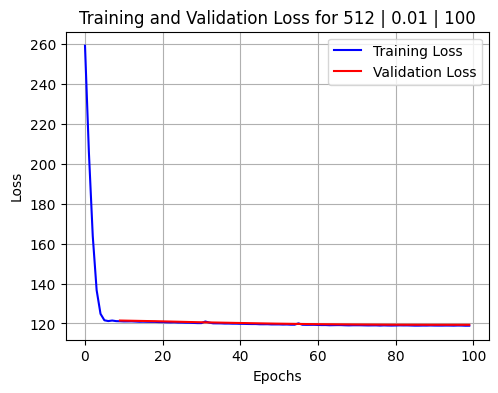

Test Loss for 512 | 0.01 | 100: 122.5276


In [8]:
test_results["512 | 0.01  | 100"] =  train_and_test_model("512 | 0.01 | 100", input_size=12, hidden_size=512, dropout=0.2, lr=0.01, num_epochs=100)

Epoch [10/100], Train Loss: 217.9285, Val Loss: 212.6032, LR: 0.000976
Epoch [20/100], Train Loss: 164.9073, Val Loss: 160.8168, LR: 0.000905
Epoch [30/100], Train Loss: 125.0121, Val Loss: 122.0182, LR: 0.000794
Epoch [40/100], Train Loss: 92.9511, Val Loss: 90.7466, LR: 0.000655
Epoch [50/100], Train Loss: 71.4824, Val Loss: 70.1623, LR: 0.000500
Epoch [60/100], Train Loss: 57.5767, Val Loss: 56.8945, LR: 0.000345
Epoch [70/100], Train Loss: 49.2717, Val Loss: 48.9593, LR: 0.000206
Epoch [80/100], Train Loss: 45.0014, Val Loss: 44.7215, LR: 0.000095
Epoch [90/100], Train Loss: 43.1384, Val Loss: 43.0976, LR: 0.000024
Epoch [100/100], Train Loss: 42.7658, Val Loss: 42.8402, LR: 0.000000


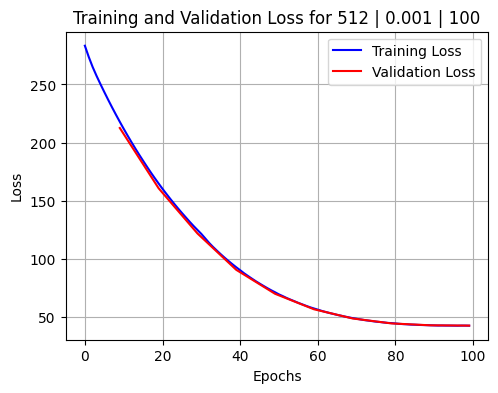

Test Loss for 512 | 0.001 | 100: 46.0157


In [9]:
test_results["512 | 0.001 | 100"] =  train_and_test_model("512 | 0.001 | 100", input_size=12, hidden_size=512, dropout=0.2, lr=0.001, num_epochs=100)           

Epoch [10/300], Train Loss: 217.5494, Val Loss: 212.1606, LR: 0.000997
Epoch [20/300], Train Loss: 161.7609, Val Loss: 157.4814, LR: 0.000989
Epoch [30/300], Train Loss: 117.8173, Val Loss: 114.7186, LR: 0.000976
Epoch [40/300], Train Loss: 81.5798, Val Loss: 79.3015, LR: 0.000957
Epoch [50/300], Train Loss: 53.3382, Val Loss: 52.4006, LR: 0.000933
Epoch [60/300], Train Loss: 35.5458, Val Loss: 34.8343, LR: 0.000905
Epoch [70/300], Train Loss: 25.4874, Val Loss: 25.1228, LR: 0.000872
Epoch [80/300], Train Loss: 20.7333, Val Loss: 19.6847, LR: 0.000835
Epoch [90/300], Train Loss: 18.8886, Val Loss: 17.8504, LR: 0.000794
Epoch [100/300], Train Loss: 17.7555, Val Loss: 16.6791, LR: 0.000750
Epoch [110/300], Train Loss: 17.2759, Val Loss: 16.2996, LR: 0.000703
Epoch [120/300], Train Loss: 16.8501, Val Loss: 16.0510, LR: 0.000655
Epoch [130/300], Train Loss: 16.5792, Val Loss: 15.3254, LR: 0.000604
Epoch [140/300], Train Loss: 16.4142, Val Loss: 15.3183, LR: 0.000552
Epoch [150/300], Train 

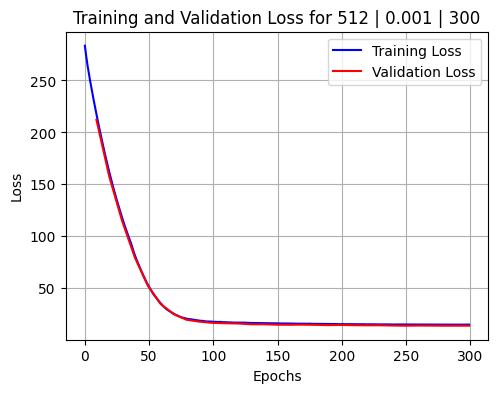

Test Loss for 512 | 0.001 | 300: 12.5533


In [10]:
test_results["512 | 0.001 | 300"] =  train_and_test_model("512 | 0.001 | 300", input_size=12, hidden_size=512, dropout=0.2, lr=0.001, num_epochs=300)           

Epoch [10/100], Train Loss: 166.0065, Val Loss: 159.5536, LR: 0.000976
Epoch [20/100], Train Loss: 82.7807, Val Loss: 79.1640, LR: 0.000905
Epoch [30/100], Train Loss: 37.9073, Val Loss: 36.7541, LR: 0.000794
Epoch [40/100], Train Loss: 20.4498, Val Loss: 20.5917, LR: 0.000655
Epoch [50/100], Train Loss: 16.0696, Val Loss: 16.1403, LR: 0.000500
Epoch [60/100], Train Loss: 14.8277, Val Loss: 15.1169, LR: 0.000345
Epoch [70/100], Train Loss: 14.2904, Val Loss: 14.6165, LR: 0.000206
Epoch [80/100], Train Loss: 13.9893, Val Loss: 14.4324, LR: 0.000095
Epoch [90/100], Train Loss: 13.8245, Val Loss: 14.2612, LR: 0.000024
Epoch [100/100], Train Loss: 13.7594, Val Loss: 14.1978, LR: 0.000000


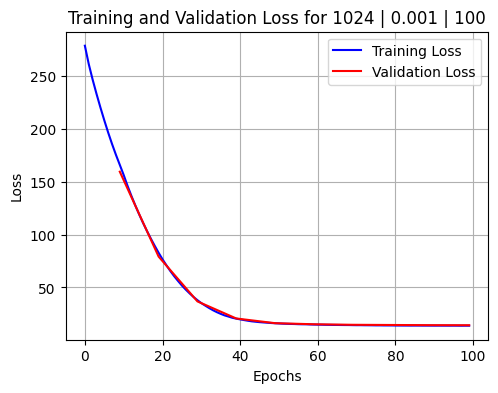

Test Loss for 1024 | 0.001 | 100: 13.1622


In [11]:
test_results["1024 | 0.001 | 100"] = train_and_test_model("1024 | 0.001 | 100", input_size=12, hidden_size=1024, dropout=0.2, lr=0.001, num_epochs=100)

In [12]:
for k, v in test_results.items():
    print(f"Test Loss for {k}: {v:.4f}")

Test Loss for 512 | 0.01  | 100: 122.5276
Test Loss for 512 | 0.001 | 100: 46.0157
Test Loss for 512 | 0.001 | 300: 12.5533
Test Loss for 1024 | 0.001 | 100: 13.1622
